# Evaluate performance

In [114]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

import shap

from scipy.stats import pearsonr, randint, uniform

import matplotlib.pyplot as plt
import matplotlib.cm

In [115]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set global variables

In [117]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [118]:
MARKET = "NEM" # "NEM" or "EU"

In [119]:
# REGION = "NSW"

In [120]:
# REMOVE_WEEKEND = False

In [121]:
# REMOVE_XMAS = False

In [122]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [123]:
# MASK_NAME = "pop_dens_mask"

In [124]:
TIME_COLUMNS = ["is_weekend"]

In [125]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2016

In [126]:
FIRST_TEST_YEAR = 2017
LAST_TEST_YEAR = 2019

In [127]:
# N_FEATURES = "best"

### Read feature data

In [131]:
def read_feature_results(mask_name, rm_weekend, rm_xmas, n_features):
    """
    Read in feature selection dataframes as dictionary items
    """
    results = dict()
    for r in regions:
        filename = fn.get_filename(
            "feature_selection_results", MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH, n_features
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + "feature_selection/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

In [132]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

In [136]:
# Population density mask, all data
features_dict_best = read_feature_results("pop_dens_mask", False, False, "best")
features_dict_pars = read_feature_results("pop_dens_mask", False, False, "parsimonious")

In [137]:
features_dict_best["NSW"].head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,selected_features
1,"(15,)",[-12032.12634008 -12709.37474908 -11388.006184...,-11633.182289,['hdd3'],659.204486,682.863092,278.777690,False
2,"(0, 15)",[-8780.50068176 -9163.20407944 -8380.05594135 ...,-8428.676304,"['is_weekend', 'hdd3']",456.297902,472.674265,192.968461,False
3,"(0, 3, 15)",[-6546.42224014 -6888.74937117 -5695.42862145 ...,-6312.857300,"['is_weekend', 'msdwswrf', 'hdd3']",382.056762,395.768638,161.571870,False
4,"(0, 3, 15, 16)",[-5494.42170587 -5813.28549908 -4874.62556786 ...,-5406.481065,"['is_weekend', 'msdwswrf', 'hdd3', 't2m']",342.686297,354.985182,144.922094,False
5,"(0, 3, 8, 15, 16)",[-5381.71894911 -5695.40491658 -4958.46416182 ...,-5251.839213,"['is_weekend', 'msdwswrf', 't2max', 'hdd3', 't...",307.196164,318.221321,129.913310,False


In [32]:
# No mask, all data
features_no_mask_dict_best = read_feature_results("no_mask", False, False, "best")
features_no_mask_dict_pars = read_feature_results("no_mask", False, False, "parsimonious")

In [33]:
# Log(population density) mask, all data
features_log_mask_dict_best = read_feature_results("pop_dens_log_mask", False, False, "best")
features_log_mask_dict_pars = read_feature_results("pop_dens_log_mask", False, False, "parsimonious")

In [34]:
# Population density mask, remove weekends and Xmas
features_no_wknd_no_xmas_dict_best = read_feature_results("pop_dens_mask", True, True, "best")
features_no_wknd_no_xmas_dict_pars = read_feature_results("pop_dens_mask", True, True, "parsimonious")

In [78]:
def plot_feature_selection(ax, results, label, pars_results=None, col1="tab:blue", col2="tab:red"):
    """
    Plot average score +/- standard deviation
    
    ax: axes
    result: pandas dataframe with avg_score and std_dev columns
    label: str, label for legend
    pars_results: pandas dataframe with avg_score and std_dev columns, to mark another point e.g. most parsimonious model
    """
    avg_score = results["avg_score"].values
    std = results["std_dev"].values
    score_max = np.where(results["selected_features"] == True)[0][0]
    
    p = ax.plot(avg_score, marker="o", c=col1, zorder=1, label=label)
    ax.fill_between(range(len(std)), avg_score + std, avg_score - std, alpha=0.3, color=col1, zorder=1)
    ax.scatter(range(len(avg_score))[score_max], avg_score[score_max], zorder=2, c=col2, marker="x", s=100)
    
    if pars_results is not None:
        pars_score = np.where(pars_results["selected_features"] == True)[0][0]
        ax.scatter(range(len(avg_score))[pars_score], avg_score[pars_score], zorder=2, c=col2, marker="+", s=100)
    
    ax.axes.grid(zorder=0)
    ax.set_axisbelow(True)
    ax.set_xticks(range(len(avg_score)))
    ax.set_xticklabels(range(1, len(avg_score) + 1))
    ax.set_xlabel("Number of features")
    ax.set_ylabel("neg_mean_absolute_error")
    
    return p

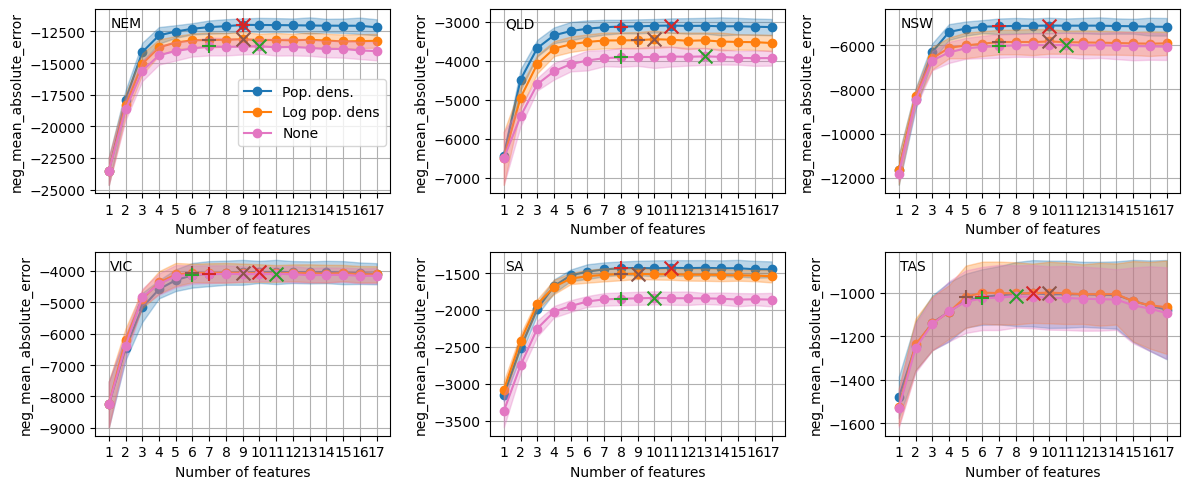

In [80]:
fig, ax = plt.subplots(2, 3, figsize=(12,5))
for i, r in enumerate(regions):
    p1 = plot_feature_selection(
        ax.flatten()[i],
        features_dict_best[r],
        "Pop. dens.",
        features_dict_pars[r]
    )
    p2 = plot_feature_selection(
        ax.flatten()[i],
        features_log_mask_dict_best[r],
        "Log pop. dens",
        features_log_mask_dict_pars[r],
        col1="tab:orange", 
        col2="tab:brown"
    )
    p3 = plot_feature_selection(
        ax.flatten()[i],
        features_no_mask_dict_best[r],
        "None",
        features_no_mask_dict_pars[r],
        col1="tab:pink",
        col2="tab:green"
    )
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
handles, labels = ax.flatten()[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2, 0.7))
    
plt.tight_layout()

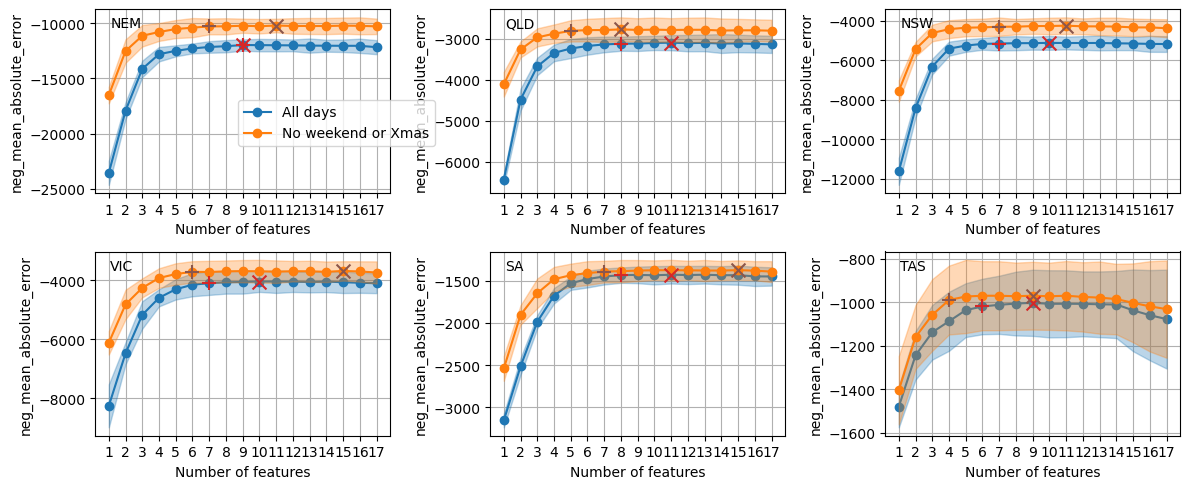

In [82]:
fig, ax = plt.subplots(2, 3, figsize=(12,5))
for i, r in enumerate(regions):
    p1 = plot_feature_selection(
        ax.flatten()[i],
        features_dict_best[r],
        "All days",
        features_dict_pars[r]
    )
    p2 = plot_feature_selection(
        ax.flatten()[i],
        features_no_wknd_no_xmas_dict_best[r],
        "No weekend or Xmas",
        features_no_wknd_no_xmas_dict_pars[r],
        col1="tab:orange",
        col2="tab:brown"
    )
    ax.flatten()[i].text(0.05, 0.9, r, transform=ax.flatten()[i].transAxes)
    
handles, labels = ax.flatten()[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2, 0.7))
    
plt.tight_layout()

# Hyperparameters

In [83]:
def read_hyperparameter_results(mask_name, rm_weekend, rm_xmas, n_features):
    """
    Read in feature selection dataframes as dictionary items
    """
    results = dict()
    for r in regions:
        filename = fn.get_filename(
            "hyperparameters", MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH, n_features
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + "hyperparameters/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

In [84]:
# Population density mask, all data
hyperparameters_dict = read_hyperparameter_results("pop_dens_mask", False, False, "parsimonious")

In [85]:
# Population density mask, remove weekends and Xmas
hyperparameters_no_wknd_no_xmas_dict = read_hyperparameter_results("pop_dens_mask", True, True, "parsimonious")

In [86]:
hyperparameters_dict

{'NEM':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'QLD':                     0
 max_depth          40
 max_leaf_nodes    143
 min_samples_leaf    8
 n_estimators      282,
 'NSW':                     0
 max_depth          42
 max_leaf_nodes    147
 min_samples_leaf    6
 n_estimators      398,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'SA':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'TAS':                     0
 max_depth          28
 max_leaf_nodes    175
 min_samples_leaf    6
 n_estimators      319}

In [87]:
hyperparameters_no_wknd_no_xmas_dict

{'NEM':                     0
 max_depth          37
 max_leaf_nodes    142
 min_samples_leaf    6
 n_estimators      299,
 'QLD':                     0
 max_depth          13
 max_leaf_nodes     65
 min_samples_leaf   10
 n_estimators      247,
 'NSW':                     0
 max_depth          46
 max_leaf_nodes    130
 min_samples_leaf    5
 n_estimators      273,
 'VIC':                     0
 max_depth          21
 max_leaf_nodes    156
 min_samples_leaf    6
 n_estimators      409,
 'SA':                     0
 max_depth          21
 max_leaf_nodes    177
 min_samples_leaf    5
 n_estimators      415,
 'TAS':                     0
 max_depth          29
 max_leaf_nodes    136
 min_samples_leaf    8
 n_estimators      336}

# Prediction skill

### Load predictions and observations

In [88]:
def read_training_results(mask_name, rm_weekend, rm_xmas, n_features):
    """
    Read in training set observations and predictions dataframes as dictionary items
    """
    results = dict()
    for r in regions:
        filename = fn.get_filename(
            "training_predictions", MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH, n_features
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + "training/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

In [89]:
def read_test_results(mask_name, rm_weekend, rm_xmas, n_features):
    """
    Read in test set observations and predictions dataframes as dictionary items
    """
    results = dict()
    for r in regions:
        filename = fn.get_filename(
            "test_predictions", MARKET, r, mask_name,
            FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
            rm_weekend, rm_xmas, REMOVE_MONTH, n_features
        )
        results[r] = pd.read_csv(
            RESULTS_PATH + "test/random_forest/" + filename + ".csv",
            index_col=0
        )
    return results

In [90]:
# Population density mask, all data
training_dict_best = read_training_results("pop_dens_mask", False, False, "best")
training_dict_pars = read_training_results("pop_dens_mask", False, False, "parsimonious")

test_dict_best = read_test_results("pop_dens_mask", False, False, "best")
test_dict_pars = read_test_results("pop_dens_mask", False, False, "parsimonious")

In [92]:
# # Population density mask, remove weekends and Xmas
# training_no_wknd_no_xmas_dict = read_training_results("pop_dens_mask", True, True)
# test_no_wknd_no_xmas_dict = read_test_results("pop_dens_mask", True, True)

In [93]:
metric_names = ["r", "R2", "MAE", "MSE", "MAPE", "MedAE"]

In [94]:
# scikit learn metrics (correlation will be computed too, within fn.compute_scores)
sklearn_metrics = [
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error
]

In [95]:
def get_scores(res_dict, metrics, metric_names):
    """
    Compute the scores for each region in res_dict.
    """
    df = pd.DataFrame(index=res_dict.keys(), columns=metric_names)
    for r in res_dict.keys():
        scores = fn.compute_scores(res_dict[r]["observation"], res_dict[r]["prediction"], metrics)
        df.loc[r] = [scores[i] for i in range(-1, 5)]
    return df

In [96]:
training_scores_best = get_scores(training_dict_best, sklearn_metrics, metric_names)
training_scores_pars = get_scores(training_dict_pars, sklearn_metrics, metric_names)

In [97]:
# training_no_wknd_no_xmas_scores = get_scores(training_no_wknd_no_xmas_dict, sklearn_metrics, metric_names)

In [98]:
test_scores_best = get_scores(test_dict_best, sklearn_metrics, metric_names)
test_scores_pars = get_scores(test_dict_pars, sklearn_metrics, metric_names)

In [99]:
# test_no_wknd_no_xmas_scores = get_scores(test_no_wknd_no_xmas_dict, sklearn_metrics, metric_names)

In [100]:
training_scores_best

,r,R2,MAE,MSE,MAPE,MedAE
NEM,0.932034,0.866484,9521.779598,175505934.066376,0.018473,7577.281052
QLD,0.931507,0.86611,2451.406467,11823122.234653,0.016974,1913.966477
NSW,0.93749,0.877325,4132.510774,33206067.566447,0.021654,3258.360571
VIC,0.940936,0.88285,3160.025575,18671038.447404,0.0256,2489.066463
SA,0.955216,0.90952,1121.985758,2175868.897163,0.034057,915.514437
TAS,0.90252,0.81183,814.403074,1106720.028912,0.030919,661.494145


In [101]:
test_scores_best

,r,R2,MAE,MSE,MAPE,MedAE
NEM,0.90781,0.820572,11918.733227,263079397.714663,0.022613,9218.617925
QLD,0.934597,0.854947,3412.001825,20747627.184303,0.022696,2612.040113
NSW,0.926699,0.853338,4769.936786,46716520.204119,0.024152,3500.300996
VIC,0.905771,0.816786,4289.530688,33410981.322426,0.03429,3298.42303
SA,0.926492,0.856454,1584.795002,4069031.11206,0.047153,1334.424447
TAS,0.882104,0.774913,957.582233,1445410.321275,0.035955,788.071346


In [102]:
def barplot(ax, metric, train_df, test_df):
    """
    Barplot of metric for each region
    """
    x = range(17)

    y = np.full(17, np.nan)
    y[[0, 3, 6, 9, 12, 15]] = train_df[metric]
    y[[1, 4, 7, 10, 13, 16]] = test_df[metric]

    colors = [matplotlib.cm.get_cmap("Pastel2")(j) for j in range(6) for _ in range(3)]

    ax.bar(x, y, color=colors)
    
    xticks = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16]
    ax.set_xticks(xticks)
    ax.set_xticklabels(["Train", "Test"] * 6, rotation=45)
    
    ax.set_ylabel(metric)

    # for ix, r in zip([xticks[i] for i in range(0, len(xticks), 2)], training_scores.index):
    #     ax.text(ix, -0.15, r)
    
    for ix, r in zip([0.04, 0.2, 0.35, 0.54, 0.71, 0.87], train_df.index):
        ax.text(ix, -0.35, r, transform=ax.transAxes)

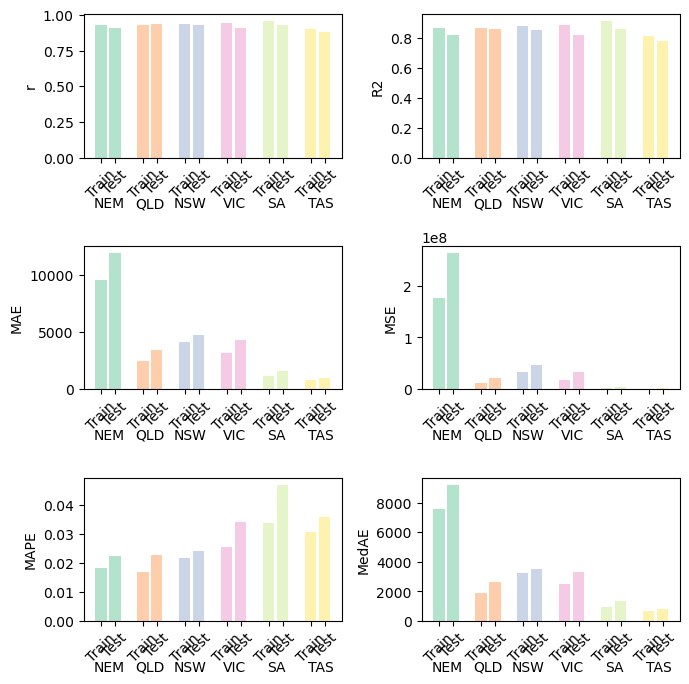

In [103]:
fig, ax = plt.subplots(3, 2, figsize=(7, 7))

for i, m in enumerate(metric_names):
    barplot(ax.flatten()[i], m, training_scores_best, test_scores_best)
    
plt.tight_layout()

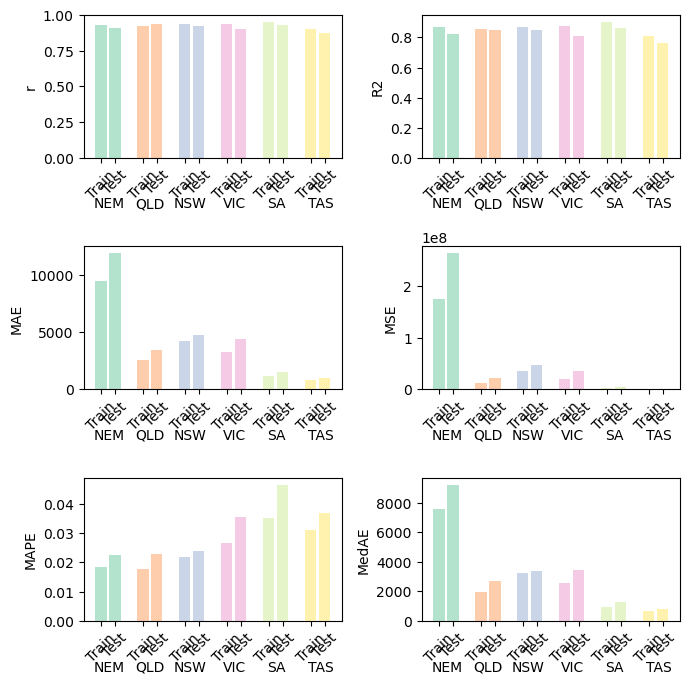

In [104]:
fig, ax = plt.subplots(3, 2, figsize=(7, 7))

for i, m in enumerate(metric_names):
    barplot(ax.flatten()[i], m, training_scores_pars, test_scores_pars)
    
plt.tight_layout()

# Predictions figures

In [107]:
def plot_ts(ax, region, tra_dict, tes_dict, start=None, end=None):
    """
    Plot observation and prediction time series for a region, for a specified period.
    """
    y = pd.concat([tra_dict[region], tes_dict[region]])
    y.index = pd.to_datetime(y.index)
    y = y / 1000 # MWh to GWh

    y.loc[slice(start, end)].plot(ax=ax)
    ax.axvline(pd.Timestamp("2017"), color="k")
    ax.set_ylabel("GWh per day")
    ax.legend(loc="lower left")
    ax.text(0.01, 0.9, region, transform=ax.transAxes)

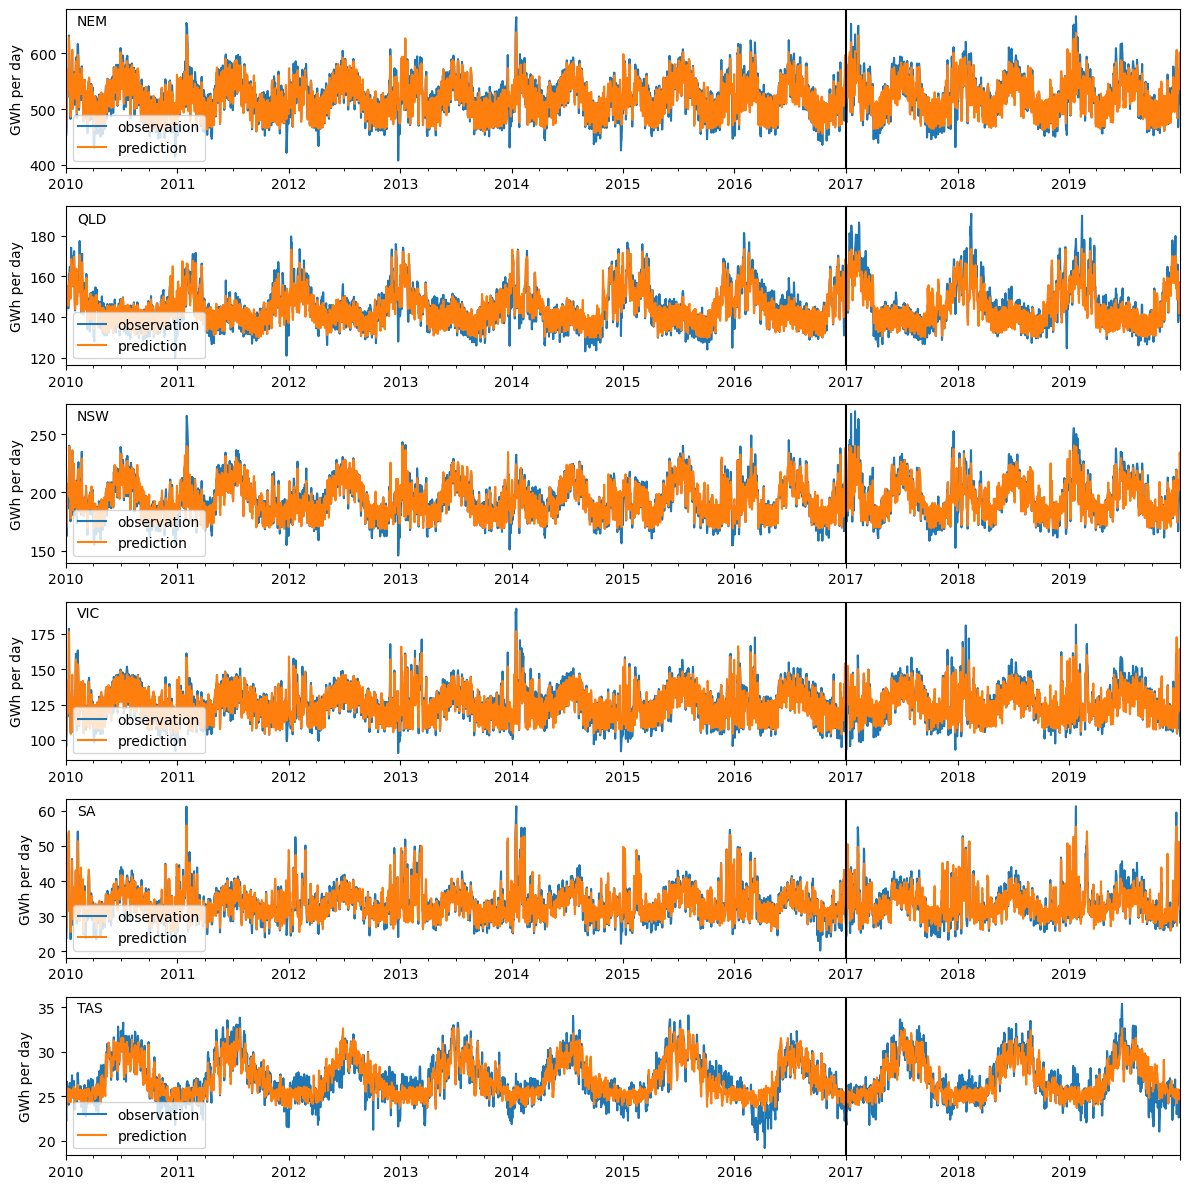

In [109]:
fig, ax = plt.subplots(6, 1, figsize=(12,12))

for i, r in enumerate(test_scores_pars.index):
    plot_ts(ax[i], r, training_dict_pars, test_dict_pars)
plt.tight_layout()

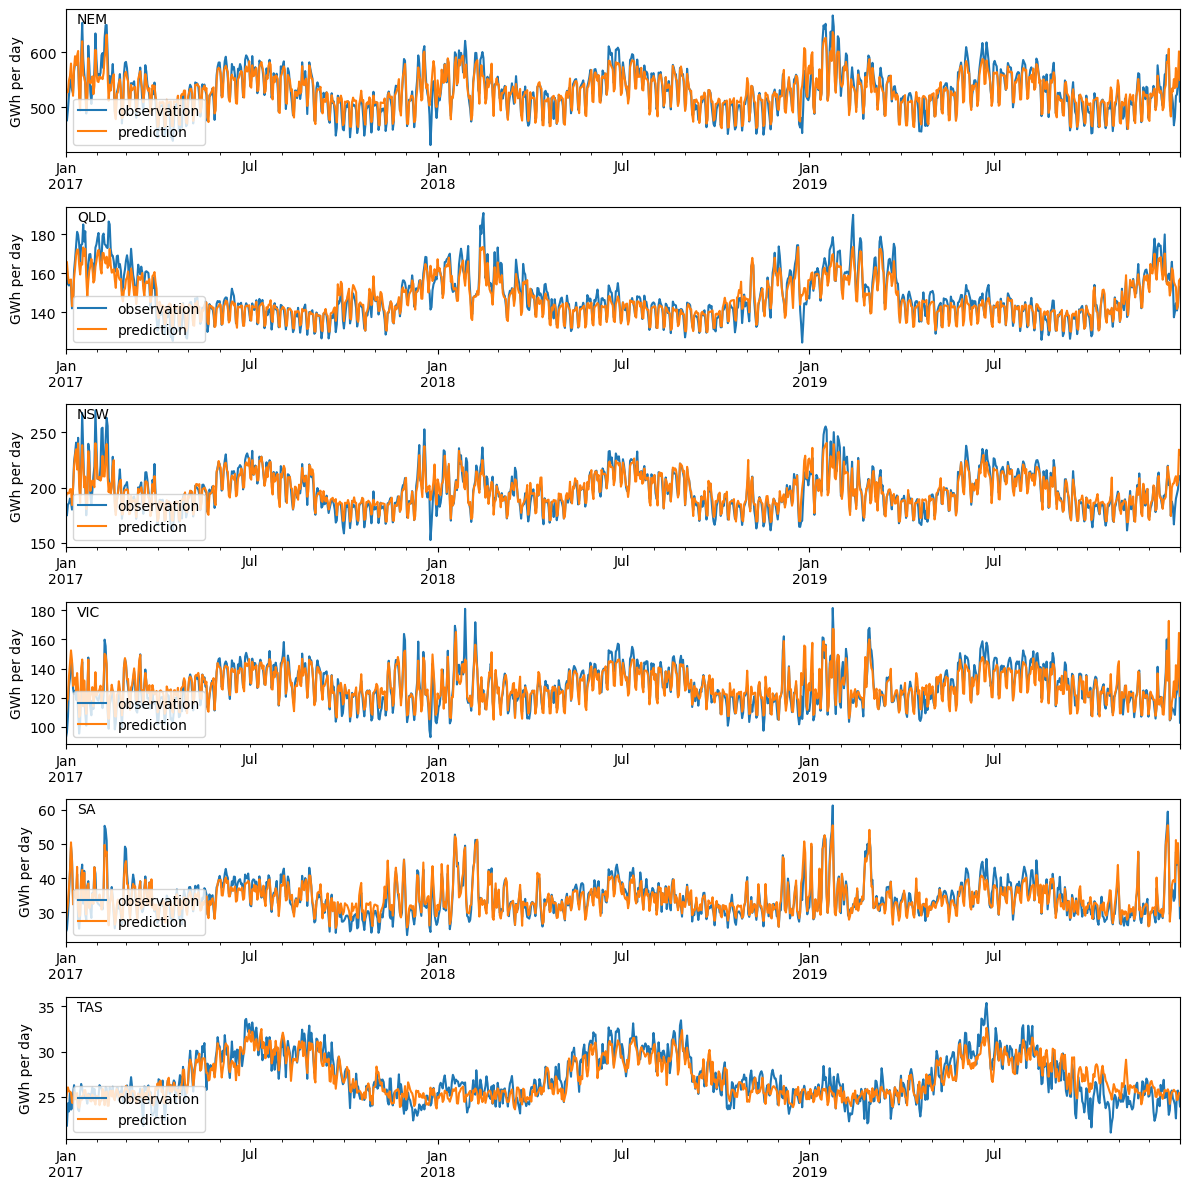

In [110]:
fig, ax = plt.subplots(6, 1, figsize=(12,12))

for i, r in enumerate(test_scores_pars.index):
    plot_ts(ax[i], r, training_dict_pars, test_dict_pars, start="2017", end="2020")
plt.tight_layout()

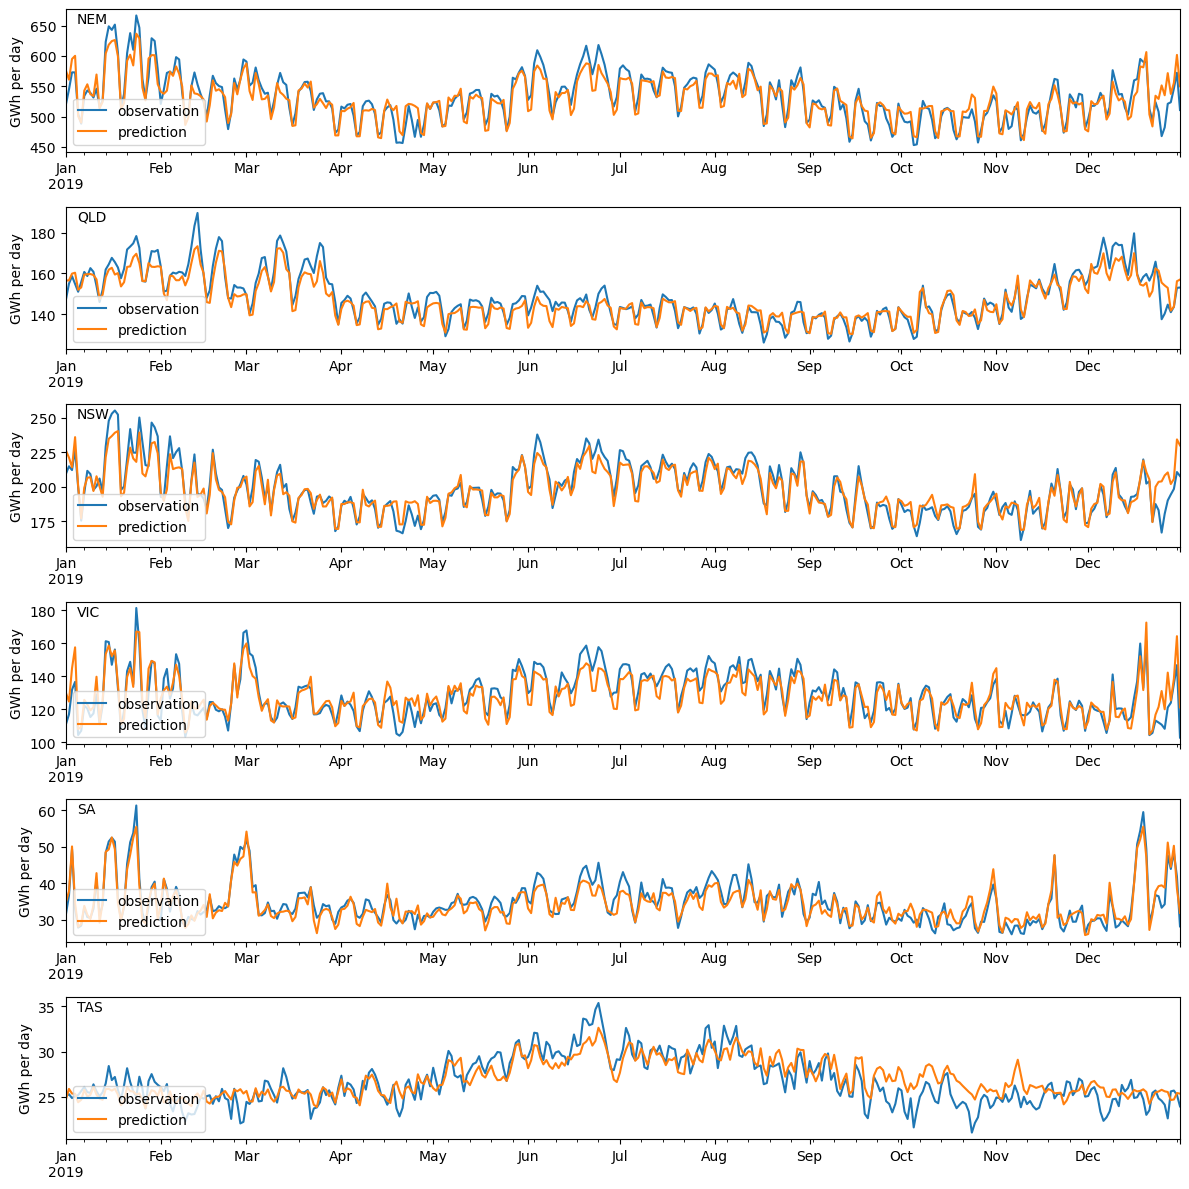

In [111]:
fig, ax = plt.subplots(6, 1, figsize=(12,12))

for i, r in enumerate(test_scores_pars.index):
    plot_ts(ax[i], r, training_dict_pars, test_dict_pars, start="2019", end="2020")
plt.tight_layout()

# Boxplot of errors, which will show differences in positive and negative? Colour by temperature/season or split?

# Permutation importances - Need to fit model again using hyperparameters saved

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [78]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=200,
)

In [79]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=200,
)

In [80]:
perm_train

{'importances_mean': array([0.13995164, 0.01626925, 0.10572489, 0.07931434, 0.05082711,
        0.11471596, 0.02440561, 0.00493057, 0.03010124, 0.01219024]),
 'importances_std': array([0.00767917, 0.00085208, 0.00473147, 0.00350224, 0.00266331,
        0.00494296, 0.00123989, 0.00032476, 0.00184531, 0.00062019]),
 'importances': array([[0.13823381, 0.14006429, 0.13473595, ..., 0.14147323, 0.15898924,
         0.14590845],
        [0.01666628, 0.01584424, 0.01472775, ..., 0.01520337, 0.01683122,
         0.01746151],
        [0.09569864, 0.10335834, 0.11467901, ..., 0.10444087, 0.09852746,
         0.10132439],
        ...,
        [0.00420485, 0.00487804, 0.00512109, ..., 0.00493622, 0.00463681,
         0.00488321],
        [0.02698144, 0.03150382, 0.03180216, ..., 0.03053448, 0.0288593 ,
         0.03003869],
        [0.01080903, 0.01258779, 0.01293996, ..., 0.01263043, 0.01205979,
         0.01205937]])}

In [81]:
perm_test

{'importances_mean': array([0.07746051, 0.00150864, 0.11290801, 0.06718211, 0.01717762,
        0.11936247, 0.00826919, 0.00018062, 0.02204301, 0.00619968]),
 'importances_std': array([0.00894955, 0.00101213, 0.00718671, 0.00447685, 0.00376282,
        0.00779727, 0.00141239, 0.00031644, 0.00335353, 0.00105301]),
 'importances': array([[ 7.85418244e-02,  7.94944138e-02,  7.75581507e-02, ...,
          7.40198859e-02,  7.20541268e-02,  7.35219301e-02],
        [ 2.74295163e-03,  1.16625889e-03, -9.18489994e-05, ...,
          2.88342405e-03,  1.37960546e-03,  1.84245141e-03],
        [ 1.17367972e-01,  1.15038405e-01,  1.17089528e-01, ...,
          9.82815625e-02,  9.94207390e-02,  1.18130334e-01],
        ...,
        [-4.57788609e-04,  3.76797985e-04, -3.18489614e-05, ...,
          4.30664278e-04,  1.58781701e-04,  4.43500560e-04],
        [ 2.41954804e-02,  2.37801136e-02,  2.25581075e-02, ...,
          2.06896959e-02,  2.22267538e-02,  2.19887514e-02],
        [ 7.13391174e-03,  

In [82]:
fn.print_perm_imp(perm_train, selected_features)

is_weekend 0.140 +/- 0.008
t2max    0.115 +/- 0.005
t2m      0.106 +/- 0.005
t2m3     0.079 +/- 0.004
w10      0.051 +/- 0.003
cdd3     0.030 +/- 0.002
msdwswrf 0.024 +/- 0.001
q        0.016 +/- 0.001
cdd4     0.012 +/- 0.001
mtpr     0.005 +/- 0.000


In [83]:
fn.print_perm_imp(perm_test, selected_features)

t2max    0.119 +/- 0.008
t2m      0.113 +/- 0.007
is_weekend 0.077 +/- 0.009
t2m3     0.067 +/- 0.004
cdd3     0.022 +/- 0.003
w10      0.017 +/- 0.004
msdwswrf 0.008 +/- 0.001
cdd4     0.006 +/- 0.001
